# Time-LLM Paper Replicating

In this notebook, we're going to replicate the TimeLLM architecture/paper with PyTorch: https://arxiv.org/abs/2310.01728

To start off, we're first going to build a minimal end-to-end implementation to validate the core workflow. Once that's working, we'll progressively scale up to the full Time-LLM (Llama-7B) architecture as described in the paper.

Workflow:


## 0. Get setup

In [169]:
# Import libraries that are pre-installed in google colab
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from typing import List, Tuple, Dict, Callable, Optional

In [170]:
# Install torchinfo
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo, installing it...")
  !pip3 install -q torchinfo
  from torchinfo import summary

In [171]:
# Setup device agnostic code
def set_device():
  if torch.cuda.is_available():
    device = "cuda"
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
  else:
    device = "cpu"
  return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


## 1. Get data

For simplicity, we're going to create a toy dataset.

In [172]:
# For completeness
import numpy as np
import pandas as pd

# Setup periods
PERIODS = 24 * 7 # one day of data

# Create datatime index
dates = pd.date_range("2025-01-01", periods=PERIODS, freq="h")

# Create sine and cos curves as toy data
sin_data = np.sin(np.linspace(0, 2 * np.pi, PERIODS))
cos_data = np.cos(np.linspace(0, 2 * np.pi, PERIODS))

# Create toy dataset
toy_df = pd.DataFrame(
    {"sin_data": sin_data,
     "cos_data": cos_data},
    index=dates
)
toy_df.head()

,sin_data,cos_data
2025-01-01 00:00:00,0.000000,1.000000
2025-01-01 01:00:00,0.037615,0.999292
2025-01-01 02:00:00,0.075177,0.997170
2025-01-01 03:00:00,0.112632,0.993637
2025-01-01 04:00:00,0.149928,0.988697


In [173]:
len(toy_df)

168

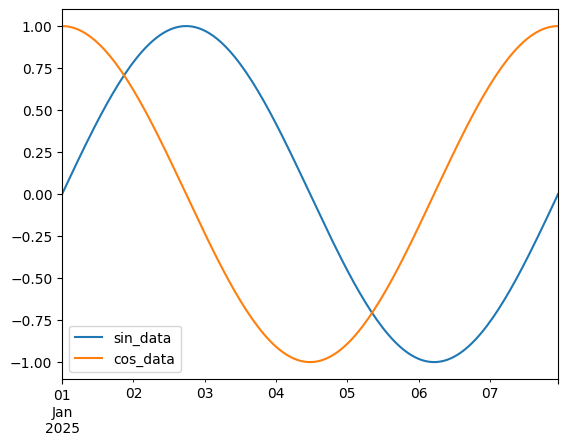

In [174]:
# Visualise data
toy_df.plot();

## 2. Create Datasets and DataLoaders

### 2.1 Split the data into training and test sets

In [175]:
# Let's split the data into training and test sets
train_split = int(len(toy_df) * 0.8)
train_df = toy_df[:train_split]
test_df = toy_df[train_split:]
print(f"[INFO] Size of the training data: {len(train_df)}")
print(f"[INFO] Size of the test data: {len(test_df)}")

[INFO] Size of the training data: 134
[INFO] Size of the test data: 34


### 2.2 Create a custom PyTorch `Dataset` to replicate `TimeSeriesDataset` from PyTorch Forecasting

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`.
2. Init our subclass with our target dataframe, (sliding) window size, forecast horizon, stride as well as a transform if we'd like to apply global transform (e.g. standardization) on our data (not necessary here).
3. Create several attributes:
* `df` - target dataset
* `window_size` - size of the sliding window, also called the history length (number of data points in the past the model uses to predict the future values)
* `forecast_horizon` - number of steps ahead the model wants to predict in the future
* `stride` - step size for sliding the input window across the time series
* `num_samples` - number of training samples
* `transform` - the (global) transform we'd like to use (not necessary here, just for completeness)
4. Overwrite the `__len__()` method to return the length of our dataset
5. Overwrite the `__getitem__()` method to return a given sample pair (in the form of a `Tuple`, `(input_window, target)`) when passed an index.

**Note:**
- Window size $\neq$ patch size! One input window could correspond to more than one patch!
- The `stride` here is not the same as the stride used in the time series patchification later!
- Given an index, want the `__getitem__()` method to return a tuple `(input_window, target)`
 - `input_window` is a tensor of shape `(number_of_channels, window_size)`
 - `target` is a tensor of shape `(number_of_channels, forcast_horizon)`, where `num_of_channels` means how many time series there are in the dataset.

In [176]:
# Write a custom dataset class and do the import
from torch.utils.data import Dataset
from typing import List, Tuple, Dict, Callable, Optional

# Subclass torch.utils.data.Dataset
class TimeSeriesDatasetCustom(Dataset):
  # Initialize our custom dataset
  def __init__(self,
               df: pd.DataFrame,
               window_size: int,
               forecast_horizon: int = 1,
               stride: int = 1,
               transform: Optional[Callable[[torch.tensor], torch.tensor]] = None): # not necessary, just for completeness
    super().__init__() # optinal here, but doesn't hurt

    # Create class attributes
    self.df = df
    self.window_size = window_size
    self.forecast_horizon = forecast_horizon
    self.stride = stride
    self.transform = transform

  # Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of training samples."
    # Calcuate number of training samples
    num_samples = (len(self.df) - self.window_size - self.forecast_horizon) // self.stride + 1
    return num_samples

  # Overwrite __getitem__() method to return a particular sample pair (input_window, target)
  def __getitem__(self, index: int) -> Tuple[torch.tensor, torch.tensor]:
    "Returns one sample of data, data and label (x, y)."
    # Normalise negative indicies
    if index < 0:
      index = len(self) + index

    start = index * self.stride
    x = self.df[start: start + self.window_size].to_numpy()
    y = self.df[start + self.window_size: start + self.window_size + self.forecast_horizon].to_numpy()

    # Convert X & y to tensors
    x = torch.from_numpy(x).type(torch.float32) # convert the datatype from float64 (Numpy's default dtype) to float32 (PyTorch's default dtype)
    y = torch.from_numpy(y).type(torch.float32)

    # Change the output shape of x (pytorch prefers channel-first)
    if x.ndim == 1: # univariate time series data
      x = x.unsqueeze(dim=0) # add channel size
    else: # multivariate time series data
      x = x.transpose(0, 1) # channel first

    # Change the output shape of y as well
    if y.ndim == 1:
      y = y.unsqueeze(dim=0) # add channel size
    else:
      y = y.transpose(0, 1) # channel first

    # Transform if necessary
    if self.transform:
      return self.transform(x), y
    else:
      return x, y

In [177]:
toy_df[:5]

,sin_data,cos_data
2025-01-01 00:00:00,0.000000,1.000000
2025-01-01 01:00:00,0.037615,0.999292
2025-01-01 02:00:00,0.075177,0.997170
2025-01-01 03:00:00,0.112632,0.993637
2025-01-01 04:00:00,0.149928,0.988697


In [178]:
# Test out TimeSeriesDatasetCustom
train_data_custom = TimeSeriesDatasetCustom(df=train_df,
                                            window_size=6,
                                            stride=5) # non-overlapping window because it is equal to the window size
test_data_custom = TimeSeriesDatasetCustom(df=test_df,
                                           window_size=6,
                                           stride=5)
train_data_custom, test_data_custom

(<__main__.TimeSeriesDatasetCustom at 0x78fd51643890>,
 <__main__.TimeSeriesDatasetCustom at 0x78fd516e4390>)

In [179]:
# Test out the __len__() method
# Print out some info about our dataset
print(f"[INFO] Size of the training dataset: {len(train_data_custom)}")
print(f"[INFO] Size of the test dataset: {len(test_data_custom)}")

[INFO] Size of the training dataset: 26
[INFO] Size of the test dataset: 6


In [180]:
# Verify the number of samples (size of the dataset - window_size)
len(train_data_custom) == (len(train_df) - 5 - 1) // 5 + 1, len(test_data_custom) == (len(test_df) - 5 - 1) // 5 + 1

(True, True)

In [181]:
# Print some more info to test out the __getitem__() method
dataset_dict = {"training": train_data_custom,
                "test": test_data_custom}

for split, dataset in dataset_dict.items():
  print(f"[INFO] Sample 0 of {split} set:")
  print(f"Data:\n{dataset[0][0]}")
  print(f"Shape: {dataset[0][0].shape}")
  print()
  print(f"Target:\n{dataset[0][1]}")
  print(f"Shape: {dataset[0][1].shape}")
  print("\n")

[INFO] Sample 0 of training set:
Data:
tensor([[0.0000, 0.0376, 0.0752, 0.1126, 0.1499, 0.1870],
        [1.0000, 0.9993, 0.9972, 0.9936, 0.9887, 0.9824]])
Shape: torch.Size([2, 6])

Target:
tensor([[0.2238],
        [0.9746]])
Shape: torch.Size([2, 1])


[INFO] Sample 0 of test set:
Data:
tensor([[-0.9463, -0.9335, -0.9193, -0.9039, -0.8871, -0.8691],
        [ 0.3233,  0.3587,  0.3935,  0.4278,  0.4615,  0.4946]])
Shape: torch.Size([2, 6])

Target:
tensor([[-0.8499],
        [ 0.5269]])
Shape: torch.Size([2, 1])




### 2.2 Turn custom loaded time series data into DataLoader's

In [182]:
import os
from torch.utils.data import DataLoader

# Setup number of workers and batch size
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 3

# Turn the custom pytorch Datasets into DataLoaders
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True,
                                     drop_last=False)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=6,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False, # no need to shuffle the test data
                                    drop_last=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78fdaca63610>,
 <torch.utils.data.dataloader.DataLoader at 0x78fd51644e10>)

In [183]:
# Print out some information of the custom dataloaders
print(f"[INFO] Train dataloader (custom) has: {len(train_dataloader_custom)} batches with number of samples: {BATCH_SIZE}")
print(f"[INFO] Test dataloader (custom) has: {len(test_dataloader_custom)} batches with number of samples: {BATCH_SIZE}")

[INFO] Train dataloader (custom) has: 9 batches with number of samples: 3
[INFO] Test dataloader (custom) has: 1 batches with number of samples: 3


In [184]:
# Get a sample from the custom train dataloader
input_window, target = next(iter(train_dataloader_custom))
input_window.shape, target.shape

(torch.Size([3, 2, 6]), torch.Size([3, 2, 1]))

## 3. Replicating TimeLLM: Overview

With the dataloader's ready, we can now proceed to replicate TimeLLM's model architecture. Before we start, it's a good practice to think about the **inputs** and **outputs**.

* Inputs - What goes into the model? A pair consisting of:
  * Input window: A segment of the time series with length `window_size`
    * Shape: `(batch_size, num_channels, window_size)`
    * E.g. `(32, 2, 48)` - 32 samples in a batch, 2 time series, window size of 48
  * Target values: The ground truth value we want our model to predict
    * Shape: `(batch_size, num_channels, forecast_horizon)`
    * E.g. `(32, 2, 24)` - 32 samples in a batch, 2 time series, 24 ground truth future values

* Outputs - What comes out of the model?
  * Predictions for future time steps
    * Shape: `(batch_size, forecast_horizon)`
    * E.g. `(32, 24)` - 32 samples in a batch, 24 predictions into the future
  
> Note: The shape of the model outpus doesn't have `num_channels` in the second dimension because our model processes each (univariate) time series subsequently.

### 3.1 TimeLLM overview: pieces of the puzzle

* Section 3 introduction + Figure 2: Paper objectives & model architecture overview
* Four components: The main four components which TimeLLM can be broken down into

#### The introduction of Section 3 outlines the objectives of this paper and provides an overview of the model architecture. Here are some snippets:

* Objective:
Our model architecture is depicted in Fig. 2. We focus on reprogramming an embedding-visible language foundation model, such as Llama (Touvron et al., 2023) and GPT-2 (Radford et al., 2019), for general time series forecasting without requiring any fine-tuning of the backbone model. Specifically, we consider the following problem: given a sequence of historical observations $\mathbf{X} \in \mathbb{R}^{N \times T}$ consisting of $N$ different 1-dimensional variables across $T$ time steps, we aim to reprogram a large language model $f(\cdot)$ to understand the input time series and accurately forecast the readings at $H$ future time steps, denoted by $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times H}$, with the overall objective to minimize the mean squared error between the ground truths $\mathbf{Y}$ and predictions:
$$
\frac{1}{H} \sum_{h=1}^H \| \hat{Y}_h - Y_h \|_F^2
$$

* Model architecture overview:
Our method encompasses three main components:
  1. input transformation
  2. a pre-trained and frozen LLM
  3. output projection.
  
  Initially, a multivariate time series is partitioned into $N$ univariate time series, which are subsequently processed independently (Nie et al., 2023). The $i$-th series is denoted as $\mathbf{X}^{(i)} \in \mathbb{R}^{1 \times T}$ which undergoes normalization, patching, and embedding prior to being reprogrammed with learned text prototypes to align the source and target modalities. Then, we augment the LLM’s time series reasoning ability by prompting it together with reprogrammed patches to generate output representations, which are projected to the final forecasts $\hat{\mathbf{Y}}^{(i)} \in \mathbb{R}^{1 \times H}$.

#### Figure 2

  <img src="https://raw.githubusercontent.com/chunyagi/ViTimeLLM/main/figures/timellm_architecture.png" width=600 alt="figure 2 from timellm paper">

### Four components

#### Section 3.1 breaks TimeLLM into four components:

1. **Input Embedding:**
Each input channel $\mathbf{X}^{(i)}$ is first individually normalized to have zero mean and unit standard deviation via reversible instance normalization (RevIN) in mitigating the time series distribution shift (Kim et al., 2021). Then, we divide $\mathbf{X}^{(i)}$ into several consecutive overlapped or non-overlapped patches (Nie et al., 2023) with length $L_p$; thus the total number of input patches
is $P = \lfloor (T − L_p ) \rfloor + 2$, where $S$ denotes the horizontal sliding stride. The underlying motivations $S$
are two-fold: (1) better preserving local semantic information by aggregating local information into each patch and (2) serving as tokenization to form a compact sequence of input tokens, reducing
computational burdens. Given these patches $\mathbf{X}_P^{(i)} \in \mathbb{R}^{P \times L_p}$ , we embed them as $\mathbf{X}_P^{(i)} \in \mathbb{R}^{P \times d_m}$
adopting a simple linear layer as the patch embedder to create dimensions $d_m$.

In summary, it can be broken down into 3 steps:
1. Normalization: zero mean and unit std
2. Patchification: patchify the input into $P$ patches, each of length $L_p$
3. Embedding: embed the patches by a simple a linear layer to change their dimensions from $L_p$ to $d_m$

**Note:** There is a hidden step that is not mentioned above. Before normalization, we need to slide an input window across the time series to create input segments.

```python
# Input Embedding
# 1. Normalisation
print(x_input.shape) # (batch_size, num_channels, window_size)
mean = x_input.mean(dim=2, keepdim=True)
std = x_input.std(dim=2, keepdim=True)
x_input_normalized = (x_input - mean) / std

# 2./3. Patchification + Embedding
# We will use a Conv1d layer to patchify and embed the patches simultaneously
patcher = Conv1d(in_channels=num_channels,
out_channel=embedding_dim,
kernel_size=patch_size,
stride=patch_size, # non-overlapping patches
padding=0) # no padding

# Perform the forward pass
x_input_patched = patcher(x_input_normalized)
print(x_input_patched.shape) # (batch_size, embedding_dim, num_patches)
# Make sure the returned sequence embedding dimensions are in the right order
x_input_patched = x_input_patched.permute(0, 2, 1) # (batch_size, num_patches, embedding_dim)
```

2. **Patch Reprogramming**: To close this gap, we propose reprogramming $\hat{\mathbf{X}}_{P}^{(i)}$ using pre-trained word embeddings $\mathbf{E} \in \mathbb{R}^{V \times D}$ in the backbone, where $V$ is the vocabulary size. Nevertheless, there is no prior knowledge indicating which source tokens are directly relevant. Thus, simply leveraging $\mathbf{E}$ will result in large and potentially dense reprogramming space. A simple solution is to maintain a small collection of text prototypes by linearly probing $\mathbf{E}$, denoted as $\mathbf{E}^{\prime} \in \mathbb{R}^{V^{\prime} \times D}$, where $V^{\prime} \ll V$. An illustration is in Fig. 3(a). Text prototypes learn connecting language cues, e.g., "short up" (red lines) and "steady down" (blue lines), which are then combined to represent the local patch information (e.g., "short up then down steadily" for characterizing patch 5) without leaving the space where the language model is pre-trained. This approach is efficient and allows for the adaptive selection of relevant source information. To realize this, we employ a multi-head crossattention layer. Specifically, for each head $k=\{1, \cdots, K\}$, we define query matrices $\mathbf{Q}_{k}^{(i)}=\hat{\mathbf{X}}_{P}^{(i)} \mathbf{W}_{k}^{Q}$, key matrices $\mathbf{K}_{k}^{(i)}=\mathbf{E}^{\prime} \mathbf{W}_{k}^{K}$, and value matrices $\mathbf{V}_{k}^{(i)}=\mathbf{E}^{\prime} \mathbf{W}_{k}^{V}$, where $\mathbf{W}_{k}^{Q} \in \mathbb{R}^{d_{m} \times d}$ and $\mathbf{W}_{k}^{K}, \mathbf{W}_{k}^{V} \in \mathbb{R}^{D \times d}$. Specifically, $D$ is the hidden dimension of the backbone model, and $d=\left\lfloor\frac{d_{m}}{K}\right\rfloor$. Then, we have the operation to reprogram time series patches in each attention head defined as:
$$
\mathbf{Z}_{k}^{(i)}=\operatorname{ATTENTION}\left(\mathbf{Q}_{k}^{(i)}, \mathbf{K}_{k}^{(i)}, \mathbf{V}_{k}^{(i)}\right)=\operatorname{SOFTMAX}\left(\frac{\mathbf{Q}_{k}^{(i)} \mathbf{K}_{k}^{(i) \top}}{\sqrt{d_{k}}}\right) \mathbf{V}_{k}^{(i)}
$$

  By aggregating each $\mathbf{Z}_{k}^{(i)} \in \mathbb{R}^{P \times d}$ in every head, we obtain $\mathbf{Z}^{(i)} \in \mathbb{R}^{P \times d_{m}}$. This is then linearly projected to align the hidden dimensions with the backbone model, yielding $\mathbf{O}^{(i)} \in \mathbb{R}^{P \times D}$.

#### Figure 3(a)

  <img src="" width=600 alt="figure 3a from timellm paper">

In summary, it can be broken down into 3 steps:
1. Create text prototypes $\mathbf{E'} \in \mathbb{R}^{V' \times D} $ by running $\mathbf{E} \in \mathbb{R}^{V \times D}$ (the word embeddings in the backbone model) through a linear layer
2. Employ a multi-head attention crossattention layer on the time series patches (queries) and text prototypes (keys and values) to align the source and target modalities
3. Run the reprogrammed patches $\mathbf{Z}^{(i)} \in \mathbb{R}^{P \times D}$ through a linear layer to align with the backbone's hidden dimensions $D$.

In pseudocode:
```python
# 1. Create text prototypes
linear_layer_for_text_prototypes = nn.Linear(in_features=vocab_size, out_features=text_prototype_size)

text_prototypes = linear_layer_for_text_prototypes(llm_word_embeddings)

# 2. Reprogramming time series patches with multi-head cross attention with text prototypes
reprogrammed_patch_embeddings = multihead_cross_attention(query=patches, key=llm_embeddings, value=llm_embeddings)

# 3. Run the reprogrammed patches through a linear layer to align with the llm's hidden dimensions
linear_layer_for_llm_hidden_dim = nn.Linear(in_features=patch_embedding_dim, out_features=llm_hidden_dim)
reprogrammed_patch_embeddings = linear_layer_for_llm_hidden_dim(reprogrammed_patch)
```

3. **Prompt-as-Prefix:** Prompts act as prefixes to enrich the input context and guide the transformation of reprogrammed time series patches.

4. **Output Projection:** Upon packing and feedforwarding the prompt and patch embeddings $\mathbf{O}^{(i)}$ through the frozen LLM as shown in Fig. 2, we discard the prefixal part and obtain the output representations. Following this, we flatten and linear project them to derive the final forecasts $\hat{\mathbf{Y}}^{(i)}$.

In pseudocode:
```python
# Input of the backbone model
prefix = [token_0, token_1, ...]
reprogammed_patch_embeddings = [patch_0, patch_1, ...]
input_embeddings = prefix + reprogrammed_patch_embeddings

# Perform forward pass to the LLM
output_embeddings = LLM(input_embeddings)

# Drop the (contextualised) prefix embeddings
output_embeddings = output_embeddings[:, prefix_length:, :] # (batch_size, num_patches, embedding_dim)

# flatten and pass them to the final forecast layer
output_embeddings_flattened = torch.flatten(output_embeddings, start_dim=1) # (batch_size, num_patches * embedding_dim)

# Create the forecast head
forecast_layer = nn.Linear(in_features=num_patches*embedding_dim,
out_features=forecast_horizen) # number of steps ahead (H)

# Pass the embedding to the forecast layer
forecast = forecast_layer(out_embeddings_flattened)
```

## 4. Component 1: Normalise the input windows, patchify them and turn them into patch embeddings

Let's remind ourselves of the steps in component 1:

> In summary, it can be broken down into 3 steps:
1. Normalization: zero mean and unit std
2. Patchification: patchify the input into $P$ patches, each of length $L_p$
3. Embedding: embed the patches by a simple a linear layer to change their dimensions from $L_p$ to $d_m$

### 4.1 Normalise the input windows (RevIN)

Before we jump into turning the patch embedding layer into a PyTorch module, we need to create a PyTorch module for RevIN (normalisation/inverse-normalisation).

Note: Not only will RevIN normalises the input time series segments (to zero mean and unit variance), but it also allows additional (per channel) scaling and shifting:
> $x_\mathrm{norm} = \gamma \cdot
(\frac{x-\mu}{\sigma+\epsilon}) + \beta$

Let's try to set up an example:

In [185]:
# Create example values
batch_size = 2
num_channels = 2
window_size = 6

# Create an example batch of input windows
torch.manual_seed(42)
example_windows = torch.randint(10, size=(batch_size, num_channels, window_size)).type(torch.float32) # (batch size, num_channels, window_size)
print(f"Example input time window:\n{example_windows}\n")

# Calculate mean and std
mean = torch.mean(example_windows, dim=2, keepdim=True)
std = torch.std(example_windows, dim=2, keepdim=True)
print(f"Example mean:\n{mean}\n")
print(f"Example standard deviation:\n{std}")
print(f"Mean/std shape: {mean.shape}\n")

# Create gamma and beta
gamma = torch.randint(10, size=(1, num_channels, 1)) # batch size is set to 1 for broadcasting
beta = torch.randint(10, size=(1, num_channels, 1))
print(f"Gamma:\n{gamma}")
print(f"Beta:\n{beta}\n")

# Normalise the examples
normalised_example_windows = (example_windows - mean) / std
print(f"Normalised example input time widow:\n{normalised_example_windows}")
affine_normalised_example_windows = normalised_example_windows * gamma + beta
print(f"Affine normalised example input window:\n{affine_normalised_example_windows}")

Example input time window:
tensor([[[2., 7., 6., 4., 6., 5.],
         [0., 4., 0., 3., 8., 4.]],

        [[0., 4., 1., 2., 5., 5.],
         [7., 6., 9., 6., 3., 1.]]])

Example mean:
tensor([[[5.0000],
         [3.1667]],

        [[2.8333],
         [5.3333]]])

Example standard deviation:
tensor([[[1.7889],
         [2.9944]],

        [[2.1370],
         [2.8752]]])
Mean/std shape: torch.Size([2, 2, 1])

Gamma:
tensor([[[9],
         [3]]])
Beta:
tensor([[[1],
         [9]]])

Normalised example input time widow:
tensor([[[-1.6771,  1.1180,  0.5590, -0.5590,  0.5590,  0.0000],
         [-1.0575,  0.2783, -1.0575, -0.0557,  1.6141,  0.2783]],

        [[-1.3259,  0.5459, -0.8579, -0.3900,  1.0139,  1.0139],
         [ 0.5797,  0.2319,  1.2753,  0.2319, -0.8115, -1.5072]]])
Affine normalised example input window:
tensor([[[-14.0935,  11.0623,   6.0312,  -4.0312,   6.0312,   1.0000],
         [  5.8275,   9.8349,   5.8275,   8.8330,  13.8423,   9.8349]],

        [[-10.9327,   5.913

### 4.2 Turn RevIN into a PyTorch module

In [186]:
import torch
from torch import nn

class RevIN(nn.Module):
  """Reversible instance normalisation ("RevIN" for short) for time series segments.

  Args:
    num_channels (int): Number of channels/time series in the dataset.
    affine (bool): If True, apply a learnable per-channel scale and bias after normalisation.
    eps (float): A small constant added to the denominator for numerical stability (prevents division by zero).

  Returns:
    (torch.tensor): Normalised (and linear transformed) input time series segments.
  """
  def __init__(self,
               num_channels: int,
               affine: bool = False, # whether you want an affine transformation after the standard normalisation or not
               eps: float = 1e-5): # added to the denominator to prevent division by zero error
    super().__init__()

    self.affine = affine
    self.eps = eps

    if affine:
      self.gamma = nn.Parameter(torch.ones(1, num_channels, 1),
                                requires_grad=True) # make sure it's learnable
      self.beta = nn.Parameter(torch.zeros(1, num_channels, 1),
                               requires_grad=True)

  def forward(self, x):
    # Calculate the mean and variance of the input segments
    self.mean = torch.mean(x, dim=2, keepdim=True) # set keepdim to True to keep the second dimension
    self.std = torch.std(x, dim=2, keepdim=True)

    # Normalise it to have zero mean and unit variance
    x_norm = (x - self.mean) / (self.std + self.eps)

    # If affine is enabled, learn a linear transformation as well
    if self.affine:
      x_norm = self.gamma * x_norm + self.beta

    return x_norm

  # Inverse normalisation to convert the input segments back to their original scale
  def inverse(self, x_norm):
    if self.affine:
      # Reverse the linear transformation process
      x_norm = (x_norm - self.beta) / (self.gamma + self.eps)

    # Reverse normalisation
    x = x_norm * self.std + self.mean

    return x

In [187]:
example_windows.shape

torch.Size([2, 2, 6])

In [188]:
# Test the RevIN class
# Create an instance of RevIN layer
revin_layer = RevIN(num_channels=2,
                    affine=True)

# Pass example windows through RevIN layer
print(f"Input time series windows:\n{example_windows}\n") # add an extra batch dimension
revin_example_windows = revin_layer(example_windows)
print(f"Output normalised time series windows:\n{revin_example_windows}\n")
inverse_revin_example_windows = revin_layer.inverse(revin_example_windows)
print(f"Output inverse normalised time series windows:\n{inverse_revin_example_windows}")

Input time series windows:
tensor([[[2., 7., 6., 4., 6., 5.],
         [0., 4., 0., 3., 8., 4.]],

        [[0., 4., 1., 2., 5., 5.],
         [7., 6., 9., 6., 3., 1.]]])

Output normalised time series windows:
tensor([[[-1.6770,  1.1180,  0.5590, -0.5590,  0.5590,  0.0000],
         [-1.0575,  0.2783, -1.0575, -0.0557,  1.6141,  0.2783]],

        [[-1.3259,  0.5459, -0.8579, -0.3900,  1.0139,  1.0139],
         [ 0.5797,  0.2319,  1.2753,  0.2319, -0.8115, -1.5071]]],
       grad_fn=<AddBackward0>)

Output inverse normalised time series windows:
tensor([[[2.0000e+00, 7.0000e+00, 6.0000e+00, 4.0000e+00, 6.0000e+00,
          5.0000e+00],
         [4.2439e-05, 4.0000e+00, 4.2439e-05, 3.0000e+00, 7.9999e+00,
          4.0000e+00]],

        [[4.1485e-05, 4.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00,
          5.0000e+00],
         [7.0000e+00, 6.0000e+00, 9.0000e+00, 6.0000e+00, 3.0000e+00,
          1.0001e+00]]], grad_fn=<AddBackward0>)


### 4.3 Calculate input and output shapes of the patch embedding layer by hand

Batch size is omitted for simplicity here

* Input shape: $N \times W$ (number of channels/time series x window size)
* Output shape: $P \times d_m$ (number of patches x hidden dimension of the patch embeddings)

In [189]:
# Create example values
input_window_size = 6 # window size (W)
num_of_channels = 2 # number of time series in the dataset (N)
patch_size = 2 # patch length (L_p)
non_overlap_stride = 2 # produce non-overlapping patches
overlap_stride = 1 # produce overlapping patches
patch_embedding_dim = 768 # patch embeddings dimension (d_m)

# Calculate the number of patches (P) with non-overlapping stride (assumed no padding)
number_of_non_overlap_patches = (input_window_size - patch_size) // non_overlap_stride + 1
print(f"Number of patches with non-overlapping stride {non_overlap_stride}: {number_of_non_overlap_patches}")

# Calculate the number of pacthes (P) with overlapping stride
number_of_overlap_patches = (input_window_size - patch_size) // overlap_stride + 1
print(f"Number of patches with overlapping stride {overlap_stride}: {number_of_overlap_patches}")

Number of patches with non-overlapping stride 2: 3
Number of patches with overlapping stride 1: 5


In [190]:
# Input shape
patch_embedding_layer_input_shape = (num_of_channels, input_window_size)

# Output shape (assumed non-overlapping stride)
patch_embedding_layer_output_shape = (number_of_non_overlap_patches, patch_embedding_dim)

print(f"Input shape ({num_of_channels} input windows): {patch_embedding_layer_input_shape}")
print(f"Output shape (1 sequence of non-overlapping patches): {patch_embedding_layer_output_shape}")

Input shape (2 input windows): (2, 6)
Output shape (1 sequence of non-overlapping patches): (3, 768)


### 4.4  Creating time series patches and turning them into patch embeddings

> Note:
The embedding method used in this implementation is probably different from the one stated in the paper. In the paper, a multivariate time series is first **partitioned into N univariate time series, which are subsequently processed independently.** But here we used a 1D convolutional layer to embed the information across all the time series **at once** into the patch embeddings. This may require a higher hidden dimension ($d_m$) to capture to capture more information from the other time series (therefore higher compute cost), but it streamlines the data flow pipeline.

In [191]:
# Create a conv1d layer to turn the time series input window into patches of learnable embeddings (patchification and embedding at the same time)
from torch import nn

# Set up the patch size (L_p)
patch_size = 2

conv1d = nn.Conv1d(in_channels=2, # number of time series
                   out_channels=768, # patch embedding dimension
                   kernel_size=patch_size,
                   stride=patch_size, # non-overlapping patches
                   padding=0) # no padding
conv1d

Conv1d(2, 768, kernel_size=(2,), stride=(2,))

In [192]:
# Get a training sample
input_window = train_data_custom[0][0]

# Remind ourselves of what the data looks like
print(f"[INFO] Input data:\n{input_window}") # take the first batch
print(f"[INFO] Shape: {input_window.shape}")

[INFO] Input data:
tensor([[0.0000, 0.0376, 0.0752, 0.1126, 0.1499, 0.1870],
        [1.0000, 0.9993, 0.9972, 0.9936, 0.9887, 0.9824]])
[INFO] Shape: torch.Size([2, 6])


In [193]:
# Pass the input window through the convolutional layer
input_window_out_of_conv = conv1d(input_window.unsqueeze(dim=0)) # add batch dimension
input_window_out_of_conv, input_window_out_of_conv.shape

(tensor([[[ 0.0678,  0.0354,  0.0032],
          [ 0.3110,  0.3450,  0.3779],
          [-0.5751, -0.5382, -0.5010],
          ...,
          [ 0.0944,  0.1089,  0.1229],
          [ 0.4817,  0.4924,  0.5003],
          [-0.0838, -0.0918, -0.0989]]], grad_fn=<ConvolutionBackward0>),
 torch.Size([1, 768, 3]))

In [194]:
input_window_out_of_conv.requires_grad # make sure it's learnable

True

Let's interpret the shape of the output tensor. 1 is the batch size, 768 means, for each patch in the 1x3 grid, it has its own embeddings of 768 dimensions.

Let's plot some random dimensions of the patch embeddings and see what they look like:

Showing random convolutional feature maps from indexes [22, 74, 286, 542, 746]


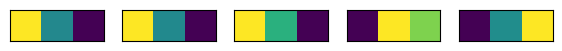

In [195]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(7, 7))

# Plot random input window feature maps
for i, idx in enumerate(random_indexes):
  input_window_feature_map = input_window_out_of_conv[:, idx, :]
  axs[i].imshow(input_window_feature_map.detach().numpy()) # remove gradient tracking and convert it to numpy array
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [196]:
# Get a single feature map in tensor form
single_feature_map = input_window_out_of_conv[:, 626, :]
single_feature_map, single_feature_map.shape # brighter color means the embedding value is larger

(tensor([[0.4053, 0.3845, 0.3617]], grad_fn=<SliceBackward0>),
 torch.Size([1, 3]))

### 4.5 Permute the patch embeddings to make sure the embedding dimension is in the right order

Right now, the shape of the output tensor from the conv1d layer is `(1, 768, 3)`, which is not what we want. We want the embedding dimension to be the last dimension: `(1, 3, 768)`.

In [197]:
# Rearrange the dimension of the output tensor from conv1d
patch_embeddings = input_window_out_of_conv.permute(0, 2, 1)
patch_embeddings.shape

torch.Size([1, 3, 768])

### 4.6 Turning the patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a layer to turn time series segments into embedding patches using `nn.Conv1d()`
2. Permute the patch embeddings dimension, i.e. `(batch_size, num_patches, embedding_dim)`

In [198]:
# Rearrange the dimension of the output tensor from conv1d
patch_embeddings = input_window_out_of_conv.permute(0, 2, 1)
patch_embeddings.shape

torch.Size([1, 3, 768])

In [199]:
from torch import nn

class PatchEmbedding(nn.Module):
  """
  Create (multivariate) time series patches and embed the patches.

  Args:
    num_channels (int): Number of time series in the dataset.
    patch_size (int): Length of the time series patches.
    stride (int): Step size for sliding the kernel across the time series.
    embedding_dim (int): Patch Embedding dimensions.
    padding (int): Number of paddings added to the beginning and the end of the input time series windows.

  Returns:
    (torch.tensor) Time series patch embeddings
  """
  def __init__(self,
               num_channels: int, # number of time series in the dataset (N)
               patch_size: int, # patch length (L_p)
               stride, # number of steps the kernel moves along the input window
               embedding_dim: int = 768, # embedding dimension of the patch embeddings
               padding: int = 0): # paddings added to both sides of the input window before convolutions
    super().__init__()

    # Create a layer to turn a time series input window into embedded patches
    self.patcher = nn.Conv1d(in_channels=num_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=stride,
                             padding=padding)

    self.patch_size = patch_size
    self.stride = stride
    self.padding = padding

  def forward(self, x):
    # Check if patch size is compatible with the input window size and stride
    input_window_size = x.shape[-1]
    if (input_window_size + 2*self.padding - self.patch_size) % self.stride != 0:
      print("Warning: Input window size is incompatible with the given patch size and stride. The last few time steps will be dropped.") # can turn this into a warning

    # Patchify the input windows and embed the patches
    x_patched = self.patcher(x)

    # Rearrange the dimension of the patches
    return x_patched.permute(0, 2, 1)

**Note:**

The `padding` parameter in `PatchEmbedding` serves two purposes:
1. Allows early and late steps to participate in more patches (get convolved a few more times), improving representations at boundaries.
2. Prevents truncation by making the input window size `L_p` compatibe with the given patch size `P` and stride `S`.

However, it doesn't support asymmetric padding right now (can work on it later with `F.pad`).

In [200]:
input_window

tensor([[0.0000, 0.0376, 0.0752, 0.1126, 0.1499, 0.1870],
        [1.0000, 0.9993, 0.9972, 0.9936, 0.9887, 0.9824]])

In [201]:
# Test the PatchEmbedding class
# Create an instance of a non-overlapping patch embedding layer
non_overlap_patchify = PatchEmbedding(num_channels=2,
                                      patch_size=2,
                                      stride=2,
                                      embedding_dim=768,
                                      padding=0)

# Pass a training example through patch embedding layer
print(f"Input sample size: {example_windows.shape}")
patch_embedded_example_windows = non_overlap_patchify(example_windows)
print(f"Output patch embeddings shape: {patch_embedded_example_windows.shape}")

Input sample size: torch.Size([2, 2, 6])
Output patch embeddings shape: torch.Size([2, 3, 768])


In [202]:
# Create an instance of an overlapping patch embedding layer
overlap_patchify = PatchEmbedding(num_channels=2,
                                  patch_size=2,
                                  stride=1,
                                  embedding_dim=768,
                                  padding=0)

# Pass a training example through patch embedding layer
print(f"Input sample size: {example_windows.shape}")
patch_embedded_example_windows = overlap_patchify(example_windows)
print(f"Output patch embeddings shape: {patch_embedded_example_windows.shape}")

Input sample size: torch.Size([2, 2, 6])
Output patch embeddings shape: torch.Size([2, 5, 768])


In [203]:
# Create an example training sample to show how paddings can help prevent truncation
example_long_windows = torch.randint(10, size=(2, 2, 26)).type(torch.float32)

# Create an instance of a patch embedding layer with no padding
no_pad_patchify = PatchEmbedding(num_channels=2,
                                 patch_size=7,
                                 stride=7,
                                 embedding_dim=768,
                                 padding=0) # no padding

print(f"Input sample size: {example_long_windows.shape}")
patch_embedded_example_long_windows_no_pad = no_pad_patchify(example_long_windows)
print(f"Output patch embeddings shape before padding: {patch_embedded_example_long_windows_no_pad.shape}")

# Create an instance of a patch embedding layer with padding
padded_patchify = PatchEmbedding(num_channels=2,
                                 patch_size=7,
                                 stride=7,
                                 embedding_dim=768,
                                 padding=1) # add padding to the beginning and the end of the input
patch_embedded_example_long_windows_with_pad = padded_patchify(example_long_windows)
print(f"Output patch embeddings shape after padding: {patch_embedded_example_long_windows_with_pad.shape}")

Input sample size: torch.Size([2, 2, 26])
Output patch embeddings shape before padding: torch.Size([2, 3, 768])
Output patch embeddings shape after padding: torch.Size([2, 4, 768])


## Component 2: Patch Reprogramming

Before we move on to create the patch reprogramming layer, it'd be handy to create a PyTorch module called `ToyWordEmbedding` to simulate LLM's pretrained word embeddings.

Let's do some experiments with `nn.Embedding`.

In [204]:
torch.manual_seed(42)
prompt = torch.randint(0, 10, size=(2, 5))
prompt

tensor([[2, 7, 6, 4, 6],
        [5, 0, 4, 0, 3]])

In [205]:
llm_word_embeddings = nn.Embedding(num_embeddings=10, # number of vocabs
                                   embedding_dim=5) # hidden dimension of word embeddings
llm_word_embeddings(prompt) # look up the word embeddings that corresponds to the indices in prompt

tensor([[[ 2.0024,  0.4664,  1.5730, -0.9228,  1.2791],
         [ 0.1754,  1.3852, -0.4459,  1.4451,  0.8564],
         [-1.5576,  0.9956,  1.5736, -0.8455,  0.3672],
         [-2.3169, -0.2168, -1.3847, -0.8712,  0.8034],
         [-1.5576,  0.9956,  1.5736, -0.8455,  0.3672]],

        [[-0.6216, -0.5920, -0.0631, -0.8286,  0.3309],
         [-0.2429, -0.9342, -0.2483, -1.2082, -0.4777],
         [-2.3169, -0.2168, -1.3847, -0.8712,  0.8034],
         [-0.2429, -0.9342, -0.2483, -1.2082, -0.4777],
         [ 1.2964, -0.4934,  0.2415, -1.1109,  0.0915]]],
       grad_fn=<EmbeddingBackward0>)

In [206]:
# Get all the word embeddings at once
# llm_word_embeddings.weight

In [207]:
# Create a pytorch module to mimic the frozen LLM's word embeddings
class ToyWordEmbedding(nn.Module):
  """
  Create toy embeddings to simulate the frozen LLM's pretrained word embeddings.

  Args:
    vocab_size (int): Number of vocabularies in the LLM's tokenizer.
    hidden_size (int): Hidden dimension of the word embeddings.

  Returns:
    (torch.Tensor): A set of toy word embeddings that are not learnable (frozen).
  """
  def __init__(self,
               vocab_size: int = 500, # number of vocabs in the tokenizer
               hidden_size: int = 512,  # hidden dimension of the word embeddings
               pretrained_weights: torch.Tensor = None): # pretrained word embeddings
    super().__init__()

    # Create word embedding layer
    self.word_embedding_layer = nn.Embedding(num_embeddings=vocab_size,
                                             embedding_dim=hidden_size)

    # Replace the random embeddings with pretrained word embeddings if there is any
    if pretrained_weights is not None:
      self.word_embedding_layer.weight.data.copy_(pretrained_weights)

    self.word_embedding_layer.weight.requires_grad = False # freeze the toy pretrained word embeddings
    self.weights = self.word_embedding_layer.weight

  # Look up word embeddings with the given input ids
  def forward(self, input_ids):
    return self.word_embedding_layer(input_ids)

In [208]:
# Test if it works
# Create random prompt
torch.manual_seed(42)
random_prompt = torch.randint(10, size=(2, 5)) # 2 sentences, 5 tokens each

# Create an instance of ToyWordEmbedding class
test_word_embedding_layer = ToyWordEmbedding()

# Look the corresponding embedding values by passing the prompt into the word embedding layer
test_word_embeddings = test_word_embedding_layer(random_prompt)
print(f"Random prompt:\n{random_prompt}\n")
print(f"The corresponding word embeddings:\n{test_word_embeddings}")

Random prompt:
tensor([[2, 7, 6, 4, 6],
        [5, 0, 4, 0, 3]])

The corresponding word embeddings:
tensor([[[-1.1787, -2.1401, -0.4903,  ..., -0.0321, -0.9898, -0.6022],
         [ 0.3538,  0.1476, -0.6777,  ..., -1.1721,  0.2123,  1.1060],
         [ 0.2218, -0.0974, -0.3662,  ...,  0.6537,  0.3624, -1.1096],
         [ 0.4451,  0.0514, -0.3501,  ..., -0.3081, -0.3388, -0.4670],
         [ 0.2218, -0.0974, -0.3662,  ...,  0.6537,  0.3624, -1.1096]],

        [[ 0.9216, -1.3966, -0.8880,  ...,  1.6771, -0.0962, -0.6807],
         [-0.2429, -0.9342, -0.2483,  ...,  0.0305,  0.5217, -0.4639],
         [ 0.4451,  0.0514, -0.3501,  ..., -0.3081, -0.3388, -0.4670],
         [-0.2429, -0.9342, -0.2483,  ...,  0.0305,  0.5217, -0.4639],
         [ 1.2455, -1.0653, -0.2282,  ..., -0.2804, -1.5083, -1.3664]]])


In [209]:
# Test if the pretrained_weights work
test_pretrained_word_embedding_layer = ToyWordEmbedding(pretrained_weights=test_word_embedding_layer.weights)
print(f"Pretrained word embeddings:\n{test_pretrained_word_embedding_layer(random_prompt)}")

Pretrained word embeddings:
tensor([[[-1.1787, -2.1401, -0.4903,  ..., -0.0321, -0.9898, -0.6022],
         [ 0.3538,  0.1476, -0.6777,  ..., -1.1721,  0.2123,  1.1060],
         [ 0.2218, -0.0974, -0.3662,  ...,  0.6537,  0.3624, -1.1096],
         [ 0.4451,  0.0514, -0.3501,  ..., -0.3081, -0.3388, -0.4670],
         [ 0.2218, -0.0974, -0.3662,  ...,  0.6537,  0.3624, -1.1096]],

        [[ 0.9216, -1.3966, -0.8880,  ...,  1.6771, -0.0962, -0.6807],
         [-0.2429, -0.9342, -0.2483,  ...,  0.0305,  0.5217, -0.4639],
         [ 0.4451,  0.0514, -0.3501,  ..., -0.3081, -0.3388, -0.4670],
         [-0.2429, -0.9342, -0.2483,  ...,  0.0305,  0.5217, -0.4639],
         [ 1.2455, -1.0653, -0.2282,  ..., -0.2804, -1.5083, -1.3664]]])


Now we can move on to the patch reprogramming layer:

Steps:
1. Create toy LLM's pretrained word embeddings with `ToyWordEmbedding`
2. Pass them through a linear layer to learn text prototypes (from vocab size $V$ to text prototype size $V'$)
3. Pass the text prototypes through another linear layer to project them from hidden size $D$ to the patch embedding dimension $d_{m}$
4. Cross attention between the patch embeddings (queries) and the learnt text prototypes (keys and values)
5. Run the reprogrammed patch embeddings through a final linear layer to align with the LLM's backbone hidden dimension $D$

In [210]:
llm_word_embeddings.weight.shape

torch.Size([10, 5])

In [211]:
class PatchReprogramming(nn.Module):
  """
  Reprogram the time series patch embeddings with text prototypes before feeding
  them into the frozen LLM to align the two different modalities (time series and text).

  Args:
    num_heads (int): Number of attention heads.
    vocab_size (int): Number of vocabularies in the LLM's tokenizer.
    text_prototype_size (int): Number of text prototypes.
    hidden_size (int): Hidden dimension of the word embeddings used in the frozen LLM (D).
    embedding_dim (int): Embedding dimension of the patch embeddings (d_m).
    attn_dropout (float): Dropout layer used in the multi-head attention layer.

  Returns:
    (torch.tensor) Reprogrammed time series patch embeddings with hidden size
    aligned with the frozen LLM (D).
  """
  def __init__(self,
               num_heads: int, # number of attention heads
               vocab_size: int = 500, # number of vocabs
               text_prototype_size: int = 100, # number of text prototypes
               hidden_size: int = 512, # hidden size of pretrained word embeddings
               embedding_dim: int = 768, # embedding dimension of patch embeddings
               attn_dropout: float = 0): # dropout layer used in attention
    super().__init__()

    # Create toy LLM's pretrained word embeddings
    self.word_embedding_layer = ToyWordEmbedding(vocab_size=vocab_size,
                                                 hidden_size=hidden_size)

    # Create a linear layer to learn text prototypes from the pretrained word embeddings (V -> V')
    self.text_prototype_linear_layer = nn.Linear(in_features=vocab_size,
                                                 out_features=text_prototype_size)

    # Create a linear layer to project the text prototypes to the same dimension as the patch embeddings (D -> d_m)
    self.text_prototype_to_patch_embedding_layer = nn.Linear(in_features=hidden_size,
                                                             out_features=embedding_dim)

    # Create multi-head cross-attention layer
    self.cross_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                            num_heads=num_heads,
                                            dropout=attn_dropout,
                                            batch_first=True) # use batch size as the first dimension (batch_size, num_patches, embedding_dim)

    # Create a linear layer to align the reprogrammed patch embeddings with the LLM's hidden size (d_m -> D)
    self.patch_embedding_to_llm_token_layer = nn.Linear(in_features=embedding_dim,
                                                        out_features=hidden_size)

  def forward(self, x):
    # Get the weights of the pretrained word embeddings and add an extra batch size dimension
    pretrained_word_embeddings = self.word_embedding_layer.weights.unsqueeze(dim=0).expand(x.shape[0], -1, -1) # shape: (batch_size, vocab_size, hidden_size)

    # Learn text prototypes
    text_prototypes = self.text_prototype_linear_layer(pretrained_word_embeddings.permute(0, 2, 1)) # permute the dimensions of pretrained word embeddings so that vocab size is last: (batch_size, hidden_size, vocab_size)

    # Project them onto the same dimension that the patch embeddings are living in
    text_prototypes = self.text_prototype_to_patch_embedding_layer(text_prototypes.permute(0, 2, 1)) # permute the dimensions again so that the hidden size is last: (batch_size, vocab_size, hidden_size)

    # Cross-attention between text prototypes and patch embeddings
    attn_output, _ = self.cross_attn(query=x,
                                     key=text_prototypes,
                                     value=text_prototypes,
                                     need_weights=False)

    # Project the attention output (reprogrammed patch embeddings) to the LLM's hidden size
    return self.patch_embedding_to_llm_token_layer(attn_output)

In [212]:
# Test if it works
print(f"Patch embeddings shape: {patch_embeddings.shape}\n")
# Create an instance of PatchReprogamming layer
patch_reprogramming_layer = PatchReprogramming(num_heads=12)

# Reprogram the patch embeddings
reprogrammed_patch_embeddings = patch_reprogramming_layer(patch_embeddings)
print(f"Reprogrammed patch embeddings:\n{reprogrammed_patch_embeddings}")
print(f"Shape (batch_size, num_patches, embedding_dim) -> (batch_size, num_patches, hidden_size): {reprogrammed_patch_embeddings.shape}")

Patch embeddings shape: torch.Size([1, 3, 768])

Reprogrammed patch embeddings:
tensor([[[ 0.0196, -0.0070, -0.0129,  ...,  0.0243,  0.0026,  0.0263],
         [ 0.0197, -0.0068, -0.0128,  ...,  0.0243,  0.0026,  0.0263],
         [ 0.0198, -0.0066, -0.0127,  ...,  0.0242,  0.0026,  0.0263]]],
       grad_fn=<ViewBackward0>)
Shape (batch_size, num_patches, embedding_dim) -> (batch_size, num_patches, hidden_size): torch.Size([1, 3, 512])


## Component 3: Prompt-as-Prefix

We'll skip this part for now because it's not necessary at this point.

## Component 4: Output Projection

With the reprogrammed patch embeddings ready, it's time to pass them (prepended with prompt) into the frozen LLM. For simplicity, instead of loading a pretrained model from Hugging Face, we'll build a toy PyTorch module that mimics a decoder-only LLM.

We can build the module with the following steps:
1. Create a multi-head attention block (multi-head attenton and add&layer norm)
2. Create a mlp block (mlp and add&layer norm)
3. Put everything together to create a transformer decoder block
4. Stack them together to mimic the decoder-only LLM structure

In [213]:
all_ones = torch.ones((5, 5), dtype=bool, device=DEVICE)
all_ones, all_ones.device

(tensor([[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]], device='cuda:0'),
 device(type='cuda', index=0))

In [214]:
torch.triu(all_ones, diagonal=1).device

device(type='cuda', index=0)

### Create a Multi-head attention Block

In [215]:
class MultiHeadAttentionBlock(nn.Module):
  """
  Create a multi-head casual self-attention block ("causal MSA block" for short).

  Returns:
    (torch.Tensor): Contextualised word embeddings (from Prompt-as-Prefix) and time series patch embeddings
  """
  def __init__(self,
               hidden_size: int = 512, # Hidden size (D)
               num_heads: int = 16, # Number of attention heads
               attn_dropout: float = 0): # Dropout layer used in attention
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size)

    # Create multi-head self-attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    # Get the number of tokens fed to the LLM
    num_tokens = x.shape[1]

    # Create a casual mask (upper triangular matrix) of shape (num_tokens, num_tokens)
    causal_mask = torch.triu(
        torch.ones((num_tokens, num_tokens), device=x.device, dtype=bool), # boolean matrix
        diagonal=1 # upper triangular excluding diagonal
    )

    # Run the input embeddings (word + time series patch embeddings) through a masked attention layer
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         attn_mask=causal_mask,
                                         need_weights=False,
                                         is_causal=True) # causal attention

    # Normalise the attention output
    return self.layer_norm(attn_output)

In [216]:
# Create an instance of MSA block
multihead_masked_attention_block = MultiHeadAttentionBlock()

# Pass the repogrammed patch embeddings through MSA block
reprogrammed_patch_embeddings_through_msa_block = multihead_masked_attention_block(reprogrammed_patch_embeddings)
print(f"Input shape of MSA block: {reprogrammed_patch_embeddings.shape}")
print(f"Output shape of MSA block: {reprogrammed_patch_embeddings_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 3, 512])
Output shape of MSA block: torch.Size([1, 3, 512])


In [217]:
reprogrammed_patch_embeddings.device

device(type='cpu')

In [218]:
next(iter(multihead_masked_attention_block.parameters())).device

device(type='cpu')

In [219]:
reprogrammed_patch_embeddings

tensor([[[ 0.0196, -0.0070, -0.0129,  ...,  0.0243,  0.0026,  0.0263],
         [ 0.0197, -0.0068, -0.0128,  ...,  0.0243,  0.0026,  0.0263],
         [ 0.0198, -0.0066, -0.0127,  ...,  0.0242,  0.0026,  0.0263]]],
       grad_fn=<ViewBackward0>)

In [220]:
reprogrammed_patch_embeddings_through_msa_block

tensor([[[ 0.4967, -0.7788,  0.7979,  ...,  0.1968,  1.5031, -2.0765],
         [ 0.4976, -0.7789,  0.7977,  ...,  0.1955,  1.5024, -2.0741],
         [ 0.4984, -0.7790,  0.7974,  ...,  0.1941,  1.5019, -2.0717]]],
       grad_fn=<NativeLayerNormBackward0>)

### Creata a MLP block

In [221]:
class MLPBlock(nn.Module):
  def __init__(self,
               hidden_size: int = 512,
               mlp_size: int = 3072,
               dropout: float = 0):
    """
    Create a fully connected layer block ("MLP block" for short).

    Notes:
      The MLP architecture (and the default parameters) used here is based on the one used in the Vision Transformer (ViT) paper.
    """
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=hidden_size,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=hidden_size),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.layer_norm(self.mlp(x)) # operation fusion

In [222]:
# Create an instance of MLPBlock
mlp_block = MLPBlock()

# Pass the output from MSABlock through MLPBlock
reprogrammed_patch_embeddings_through_mlp_block = mlp_block(reprogrammed_patch_embeddings_through_msa_block)
print(f"Input shape of MLP block: {reprogrammed_patch_embeddings_through_msa_block.shape}")
print(f"Output shape of MLP block: {reprogrammed_patch_embeddings_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 3, 512])
Output shape of MLP block: torch.Size([1, 3, 512])


In [223]:
reprogrammed_patch_embeddings_through_msa_block

tensor([[[ 0.4967, -0.7788,  0.7979,  ...,  0.1968,  1.5031, -2.0765],
         [ 0.4976, -0.7789,  0.7977,  ...,  0.1955,  1.5024, -2.0741],
         [ 0.4984, -0.7790,  0.7974,  ...,  0.1941,  1.5019, -2.0717]]],
       grad_fn=<NativeLayerNormBackward0>)

In [224]:
reprogrammed_patch_embeddings_through_mlp_block

tensor([[[ 1.7140,  0.4391, -0.1248,  ..., -0.4986,  1.1585,  0.2872],
         [ 1.7130,  0.4402, -0.1233,  ..., -0.4972,  1.1598,  0.2862],
         [ 1.7119,  0.4413, -0.1217,  ..., -0.4960,  1.1611,  0.2851]]],
       grad_fn=<NativeLayerNormBackward0>)

The transformer decoder in the LLM is a combination of alternating blocks of MSA and MLP.

Let's create a custom Transformer Decoder block:

> Why don't we use the in-built PyTorch transformer decoder layer (https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html)?
Because it'll help experimenting and debugging when we develop ViTimeLLM.

In [225]:
class TransformerDecoderBlock(nn.Module):
  """
  A transformer decoder class which is made of alternating MSA block and MLP block.
  """
  def __init__(self,
               hidden_size: int = 512,
               num_heads: int = 16,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.0,
               attn_dropout: float = 0.0):
    super().__init__()

    # Create MSA block
    self.msa_block = MultiHeadAttentionBlock(hidden_size=hidden_size,
                                             num_heads=num_heads,
                                             attn_dropout=attn_dropout)

    # Create MLP block
    self.mlp_block = MLPBlock(hidden_size=hidden_size,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual connection
    x = self.mlp_block(x) + x
    return x

In [226]:
# Create an instance of TransformerDecoderBlock
transformer_decoder_block = TransformerDecoderBlock()
next(iter(transformer_decoder_block.parameters())).device

device(type='cpu')

In [227]:
reprogrammed_patch_embeddings.device

device(type='cpu')

In [228]:
# Create an instance of TransformerDecoderBlock
transformer_decoder_block = TransformerDecoderBlock()

# Get a summary using torchinfo
# summary(model=transformer_decoder_block, # note: torchinfo.summary secretly moves your model to cuda!
#         input_size=(1, 3, 512),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

x_output = transformer_decoder_block(reprogrammed_patch_embeddings)
x_output.shape

torch.Size([1, 3, 512])

In [229]:
flatten_layer = nn.Flatten(start_dim=1)
x_output_flattened = flatten_layer(x_output)
x_output_flattened.shape

torch.Size([1, 1536])

In [230]:
3*512

1536

### Putting it all together to create Toy LLM

In [231]:
class ToyLLM(nn.Module):
  """
  A toy LLM consisting of multiple stacked transformer decoder blocks.
  """
  def __init__(self,
               num_transformer_layers: int = 12,
               hidden_size: int = 512,
               mlp_size: int = 3072,
               num_heads: int = 16,
               attn_dropout: float = 0.0,
               mlp_dropout: float = 0.0):
    super().__init__()

    # Create the Transformer Decoder blocks
    self.transformer_decoders = nn.Sequential(*[TransformerDecoderBlock(hidden_size,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout,
                                                                       attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
  def forward(self, x):
    return self.transformer_decoders(x)

In [232]:
torch.manual_seed(42)

# Create an instance of ToyLLM
toyllm = ToyLLM()

# Freeze every parameter in the toy LLM
for p in toyllm.parameters():
  p.requires_grad = False

# Pass an example reprogrammed patch embeddings to our ToyLLM
output_embeddings = toyllm(reprogrammed_patch_embeddings)

In [233]:
reprogrammed_patch_embeddings.shape

torch.Size([1, 3, 512])

In [234]:
# Check if the parameters in the toy LLM are frozen using torchinfo.summary
# summary(model=toyllm,
#         input_size=(1, 3, 512), # (batch_size, num_patches, embedding_dim)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### Output projection

Recall:
> Output Projection. Upon packing and feedforwarding the prompt and patch embeddings $\mathbf{O}^{(i)}$ through the frozen LLM as shown in Fig. 2, we discard the prefixal part and obtain the output representations. Following this, we flatten and linear project them to derive the final forecasts $\hat{\mathbf{Y}}^{(i)}$.

With the toy LLM ready, it's eventually time to put all the puzzles together. Inside our `TimeLLM` model class, we want:
1. `RevIN`: Normalise the input time windows/ re-scale the output forecast values
2. `PatchEmbedding` - Patchify the input and embed them to patch embeddings with dimension $d_m$
3. `PatchReprogramming` - Learn text prototypes and then reprogram the time series patch embeddings to align with the source representation space (text)
4. `ToyLLM` - Pass the reprogrammed patch embeddings to the frozen LLM
5. Discard the prefixal part (prompt) and flatten the output embeddings
6. Project them to final forecast with a linear head
7. Rescale the forecast with `RevIN.inverse()`



In [235]:
class TimeLLM(nn.Module):
  """
  The TimeLLM architecture replicated from the TimeLLM paper.
  """
  def __init__(self,
               num_channels: int,
               window_size: int,
               forecast_horizon: int,
               patch_size: int,
               stride: int,
               affine: bool = False,
               eps: float = 1e-5,
               embedding_dim: int = 768,
               padding: int = 0,
               reprogramming_head: int = 12,
               vocab_size: int = 500,
               text_prototype_size: int = 100,
               hidden_size: int = 512,
               reprogramming_attn_dropout: float = 0.0,
               num_transformer_layers: int = 12,
               llm_msa_heads: int = 16,
               llm_mlp_size: int = 3072,
               llm_mlp_dropout: float = 0.0,
               llm_attn_dropout: float = 0.0):
    super().__init__()

    self.num_channels = num_channels
    self.forecast_horizon = forecast_horizon

    # Calculate the number of patches
    self.num_patches = (window_size + 2*padding - patch_size) // stride + 1

    # Create a RevIN layer
    self.revin = RevIN(num_channels,
                       affine=False)

    # Create patch embedding layer
    self.patch_embedding_layer = PatchEmbedding(num_channels=num_channels,
                                                patch_size=patch_size,
                                                stride=stride,
                                                embedding_dim=embedding_dim,
                                                padding=padding)

    # Create Patch reprogramming layer
    self.patch_reprogramming_layer = PatchReprogramming(num_heads=reprogramming_head,
                                                        vocab_size=vocab_size,
                                                        text_prototype_size=text_prototype_size,
                                                        hidden_size=hidden_size,
                                                        embedding_dim=embedding_dim,
                                                        attn_dropout=reprogramming_attn_dropout)
    # Create toy LLM
    self.toy_llm = ToyLLM(num_transformer_layers=num_transformer_layers,
                          hidden_size=hidden_size,
                          mlp_size=llm_mlp_size,
                          num_heads=llm_msa_heads,
                          attn_dropout=llm_attn_dropout,
                          mlp_dropout=llm_mlp_dropout)

    # Freeze all the parameters in the toy LLM
    for p in self.toy_llm.parameters():
      p.requires_grad = False

    # Create a flatten layer
    self.flatten_layer = nn.Flatten(start_dim=1)

    # Create a forecast head
    self.forecast_head = nn.Linear(in_features=self.num_patches*hidden_size,
                                   out_features=num_channels*forecast_horizon)

  def forward(self, x):
    # 1. Normalise the input time window
    x_norm = self.revin(x)

    # 2. Turn them into patch embeddings
    patch_embeddings = self.patch_embedding_layer(x_norm)

    # 3. Reprogram the patch embeddings
    reprogrammed_patch_embeddings = self.patch_reprogramming_layer(patch_embeddings)

    # 4. Pass it to the frozen LLM
    output_embeddings = self.toy_llm(reprogrammed_patch_embeddings)

    # 5. Flatten the output embeddings
    flattened_output_embeddings = self.flatten_layer(output_embeddings)

    # 6. Project them to get normalised forecast values
    y_norm = self.forecast_head(flattened_output_embeddings).view(x.shape[0], self.num_channels, self.forecast_horizon)

    # 7. Return the rescaled forecast values
    return self.revin.inverse(y_norm)

In [236]:
x = torch.rand(size=(1, 4))
print(x)
print(x.view(1, 2, 2))

tensor([[0.5809, 0.2374, 0.0941, 0.1839]])
tensor([[[0.5809, 0.2374],
         [0.0941, 0.1839]]])


In [237]:
# Test the TimeLLM class
torch.manual_seed(42)

# Create a random input window tensor
random_input_window = torch.randn(1, 2, 6)

# Create an instance of TimeLLM
timellm = TimeLLM(num_channels=2,
                  window_size=6,
                  forecast_horizon=1,
                  patch_size=2,
                  stride=2)

# Pass the input window tensor to TimeLLM
forecast = timellm(random_input_window)
print(f"[INFO] Model output: {forecast} | Shape: {forecast.shape}")

[INFO] Model output: tensor([[[ 1.3981],
         [-1.5280]]], grad_fn=<AddBackward0>) | Shape: torch.Size([1, 2, 1])


In [238]:
# Get a summary of our TimeLLM model
# summary(model=timellm,
#         input_size=(1, 2, 6),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

## 5. Setting up training code for our custom TimeLLM

We've replicated the TimeLLM architecture (with a toy LLM), now let's set up training codes to train the model.

### 5.1 Creating an optimizer

The paper states it uses the Adam optimizer (section B.4 Model Configurations), but it doesn't mention the values for $B1$ and $B2$, so we'll just stick to the default values for now.

The paper uses different learning rates for different datasets. For now, we'll just use `10^-3`, which is used in the LTF-ETTh1 dataset.

### 5.2 Creating a loss function

The paper mentions it uses mean square error (MSE) as its loss function, we can implement it with `torch.nn.MSELoss()`

In [239]:
# timellm.state_dict()

In [240]:
# Setup loss function and optimizer
optimizer = torch.optim.Adam(params=timellm.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.MSELoss()

### 5.3 Setup training code

Let's create training and testing codes inside a function so that they can be reused in the future.

TODO:
- Do a three split instead (training-validation-test)
- Compile the model
- Use AMP
- Use `tf32` instead of `float32` (PyTorch's default)

In [241]:
# Get an example from the training dataloader
example = next(iter(train_dataloader_custom))

# Print out some info of the example
print(f"Training sample:\n{example[0]}")
print(f"Shape of training sample:\n{example[0].shape}")
print()
print(f"Label:{example[1]} | Shape: {example[1].shape}")

Training sample:
tensor([[[ 0.9679,  0.9767,  0.9841,  0.9901,  0.9947,  0.9978],
         [ 0.2512,  0.2147,  0.1778,  0.1406,  0.1033,  0.0658]],

        [[-0.8399, -0.8597, -0.8783, -0.8957, -0.9118, -0.9266],
         [-0.5428, -0.5108, -0.4781, -0.4447, -0.4107, -0.3762]],

        [[ 0.9522,  0.9400,  0.9266,  0.9118,  0.8957,  0.8783],
         [-0.3054, -0.3410, -0.3762, -0.4107, -0.4447, -0.4781]]])
Shape of training sample:
torch.Size([3, 2, 6])

Label:tensor([[[ 0.9996],
         [ 0.0282]],

        [[-0.9400],
         [-0.3410]],

        [[ 0.8597],
         [-0.5108]]]) | Shape: torch.Size([3, 2, 1])


In [242]:
forecast, forecast.shape

(tensor([[[ 1.3981],
          [-1.5280]]], grad_fn=<AddBackward0>),
 torch.Size([1, 2, 1]))

In [243]:
label = torch.rand(size=(1, 2, 1))
label

tensor([[[0.6981],
         [0.3879]]])

In [244]:
loss_fn(label, forecast)

tensor(2.0804, grad_fn=<MseLossBackward0>)

In [245]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Create training step function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
  """
  Trains a PyTorch (regression) model for a single epoch.

  Args:
    model (torch.nn.Module): A PyTorch (regression) model to be trained.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be trained on.
    loss_fn (torch.nn.Module): A PyTorch loss function to minimize.
    optimizer (torch.optim.Optimizer): A PyTorch optimizer to minimize the loss function.
    device (torch.device): A target device to compute on (e.g. "cuda", "mps" or "cpu")
  Returns:
    (float) Average training loss across the epoch.
  """
  # Put the model in train mode
  model.train()

  # Setup train loss
  train_loss = 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Adjust metrics to get average loss per batch
  train_loss = train_loss / len(dataloader)
  return train_loss

# Create test step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> float:
  """
  Tests a PyTorch (regression) model for a single epoch.

  Args:
    model (torch.nn.Module): A PyTorch (regression) model to be tested.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be trained on.
    loss_fn (torch.nn.Module): A PyTorch loss function to minimize.
    device (torch.device): A target device to compute on (e.g. "cuda", "mps" or "cpu")

  Returns:
    (float) Average test loss across the epoch.
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss
  test_loss = 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = model(X)

      # Calculate and accumulate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

  # Adjust metrics to get average loss
  test_loss = test_loss / len(dataloader)
  return test_loss

# Create a training function with train step and test step combined
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """
  Trains and tests a PyTorch model.

  Returns:
    (Dict) A dictionary of training and testing loss. Each metric has a value in a list for
      each epoch.
  """
  # Create empty results dictionary
  results = {
      "train_loss": [],
      "test_loss": []
  }

  # Make sure model on target device
  model.to(device)

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
    test_loss = test_step(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

    # Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"test_loss: {test_loss:.4f} | "
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)

  # Return the filled results at the end of the epochs
  return results

In [246]:
# Train our timellm model
result = train(model=timellm,
               train_dataloader=train_dataloader_custom,
               test_dataloader=test_dataloader_custom,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=6,
               device=DEVICE)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0713 | test_loss: 0.0175 | 
Epoch: 2 | train_loss: 0.0168 | test_loss: 0.0189 | 
Epoch: 3 | train_loss: 0.0166 | test_loss: 0.0253 | 
Epoch: 4 | train_loss: 0.0163 | test_loss: 0.0440 | 
Epoch: 5 | train_loss: 0.0114 | test_loss: 0.0613 | 
Epoch: 6 | train_loss: 0.0187 | test_loss: 0.0405 | 


## 6. Get predictions on test/custom data

Now we've trained our TimeLLM model! It's time to predict on the test set/custom data.

Let's create a function called `pred_and_plot` to make predictions and plot them.

In [ ]:
import os

import torch
from torch.utils.data import DataLoader

import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Optional

def pred_and_plot(model: torch.nn.Module,
                  dataset: pd.DataFrame,
                  columns: Optional[List[str]] = None,
                  batch_size: int = 3,
                  window_size: int = 6,
                  forecast_horizon: int = 1,
                  stride: int = 5,
                  device: torch.device = DEVICE) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Run a trained PyTorch (regression) model of time series and plot predictions vs. ground truth.

  Args:
    model (torch.nn.Module): A trained PyTorch time series forecasting model.
    dataset (pd.DataFrame): The target DataFrame you want to run inference on.
    columns (Optional[List[str]]): Target columns included in the plot.
    batch_size (int): Number of samples in each batch.
    window_size (int): Number of time steps included in each time series window.
    forecast_horizon (int): Number of time steps into the future you want the model to predict.
    stride (int): Step size for the sliding window over the time series.
    device (torch.device): A target device to run inference on (e.g. "cuda", "mps" or "cpu")

  Returns:
    (Tuple[torch.Tensor, torch.Tensor]) A tuple of ground truth labels and model predictions
      in the form of tensor. They are of shape (`num_channels`, `len_pred`), where `num_channels` is
      the number of time series in the dataset and `len_pred` is the length of model predictions.
  """
  # Create empty lists to store labels and predictions
  labels = []
  predictions = []

  # Calculate number of workers
  num_workers = os.cpu_count()

  # Turn the raw Dataframe into an instance of TimeSeriesDatasetCustom
  custom_dataset = TimeSeriesDatasetCustom(df=dataset,
                                           window_size=window_size,
                                           forecast_horizon=forecast_horizon,
                                           stride=stride)

  # Turn the custom pytorch Datasets into DataLoaders
  dataloader = DataLoader(dataset=custom_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=False,
                          drop_last=False) # don't drop the last batch

  # Make sure the model is on the target device
  model.to(device)

  # Put model in eval mode
  model.eval()

  # Turn on inference manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = model(X)

      # Append the label to a list
      labels.append(y)

      # Append the prediction to a list
      predictions.append(y_pred)

  # Concatenate predictions along the batch dimension
  all_labels = torch.cat(labels, dim=0)
  all_preds = torch.cat(predictions, dim=0)

  # Permute the batch size and number of channels and then flatten them -> (num_channels, batch_size*forecast_horizon)
  all_labels = all_labels.permute(1, 0, 2).flatten(start_dim=1)
  all_preds = all_preds.permute(1, 0, 2).flatten(start_dim=1)

  # Plot the graph
  # Check if any columns are selected, if not, defaults to all columns
  if columns is None:
    columns = list(dataset.columns)

  # Get the index of the selected columns in the dataframe column list
  column_index_list = [list(dataset.columns).index(column) for column in columns]

  # Create column names list for the labels and predictions dataframe
  column_names = columns + [f"{column}_pred" for column in columns]

  # Select the specificed columns' labels and predictions
  selected_labels = all_labels[column_index_list, :]
  selected_preds = all_preds[column_index_list, :]

  # Concatenate the labels and predictions along the columns
  label_and_pred_tensor = torch.cat([selected_labels.transpose(0, 1), selected_preds.transpose(0, 1)], dim=1)

  # Create a DataFrame to store the labels and predictions
  label_and_pred_df = pd.DataFrame(data=label_and_pred_tensor.cpu(),
                                   columns=column_names) # need to move the tensor to cpu because matplotlib works with numpy arrays

  # Plot the labels and predictions
  label_and_pred_df.plot();

  return all_labels, all_preds # each of them has shape: (num_channels, len_pred)

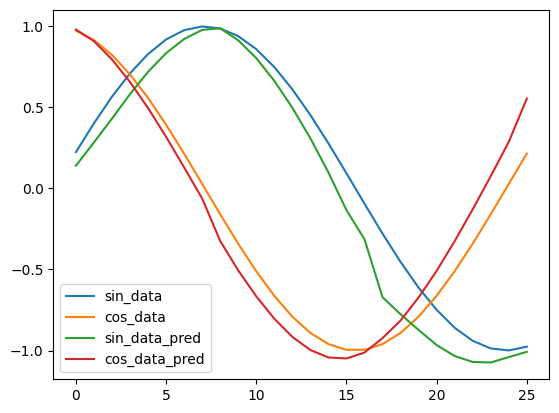

In [253]:
labels_and_preds = pred_and_plot(model=timellm,
                                 dataset=train_df)
labels, preds = labels_and_preds